In [3]:
#add questions and/or at least answer boxes?

In [4]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import warnings
import ipywidgets as widgets
from scipy.optimize import least_squares
import statsmodels.api as sm

Authored by *David J. Heeger*  1/31/2005<br>
*HY* fixed deconvolution section 1/11/2019<br>
Translated into Python by *Chrysa Papadaniil* 9/21 <br>

Thank you to Sam Pfeiffer (github handle: awesomebytes) for the convolution function.

###  1. Simulate some experiments with different trial sequences

In [5]:
TR = 1;
n_frames = 480;

`trial_sequence_1:` only 1 trial type <br>
`trial_sequence_2:` only 1 trial type <br>
`trial_sequence_3:` mixed 3 trial types

#### `trial_sequence_1:` 
Stim on for 1s (1 TR) followed by stim off for 5 sec at regular intervals. Start times of each trial indicated by 1's.

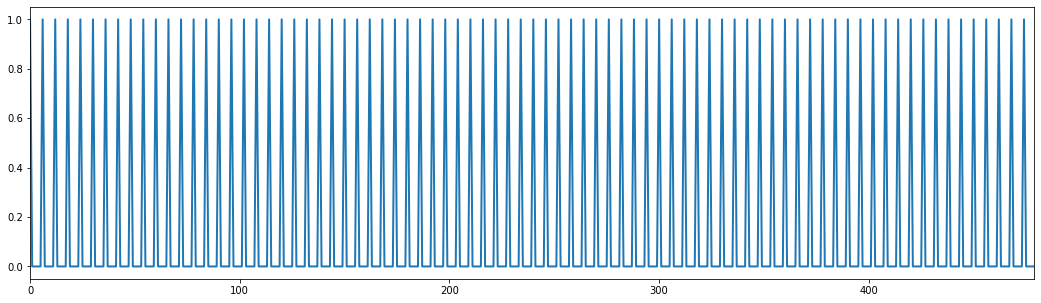

In [6]:
trial_sequence_1 = np.zeros(n_frames)
trial_sequence_1[::6] = 1

#Plot it
plt.figure(figsize=(18,5))
plt.plot(trial_sequence_1, lw=2)
plt.xlim(0, len(trial_sequence_1)-1)
warnings.filterwarnings("ignore")

### `trial_sequence_2`
Pseudo-randomized version of trial_sequence_1

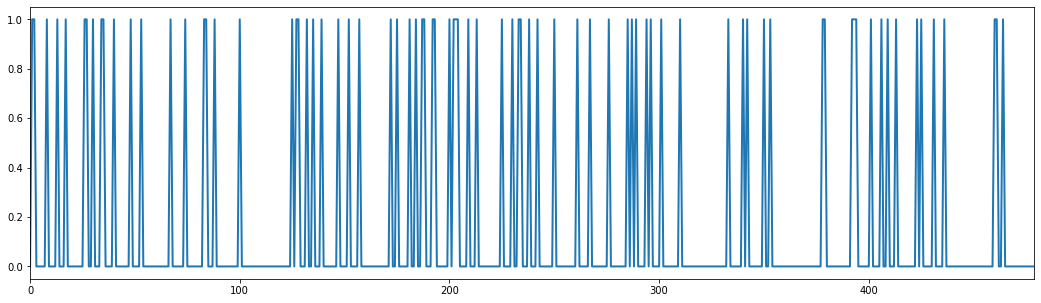

In [7]:
trial_sequence_2 = np.random.permutation(trial_sequence_1)

#Plot it
plt.figure(figsize=(18,5))
plt.plot(trial_sequence_2, lw=2)
plt.xlim(0, len(trial_sequence_2)-1)
warnings.filterwarnings("ignore")

### `trial_sequence_3`
Three different trial types in pseudo-random order. Start times of the three trial types indicated by 1's, 2's, and 3's.<br>
    Trial type 1: 2 sec stimulus presentations<br>
    Trial type 2: 4 sec stimulus presentations<br>
    Trial type 3: No stimulus<br>
All trials are separated by a 2 sec inter-trial interval.<br>

So the duration of each trial type is<br>
    Trial type 1: 4 sec (2 sec stimulus followed by 2 sec ITI)<br>
    Trial type 2: 6 sec (4 sec stimulus followed by 2 sec ITI)<br>
    Trial type 3: 2 sec (0 sec stimulus followed by 2 sec ITI)<br>

We want an equal number of each trial type. Presenting each trial once
takes 12 sec, so if the duration of the run is 240 sec, then we have time
for 20 trials of each type (20*12=240).<br>

To build the trial sequence we start by making a pseudo-random trial
order. Then we pad with the appropriate number of zeros.

In [8]:
trial_order = (np.ones(n_frames//12), 2*np.ones(n_frames//12), 3*np.ones(n_frames//12))
trial_order = np.reshape(trial_order, (np.size(trial_order),1))
trial_order = np.random.permutation(trial_order)

Note that at this point trial_order is the same as what is in the stimvec file output by the stimulus presentation program.

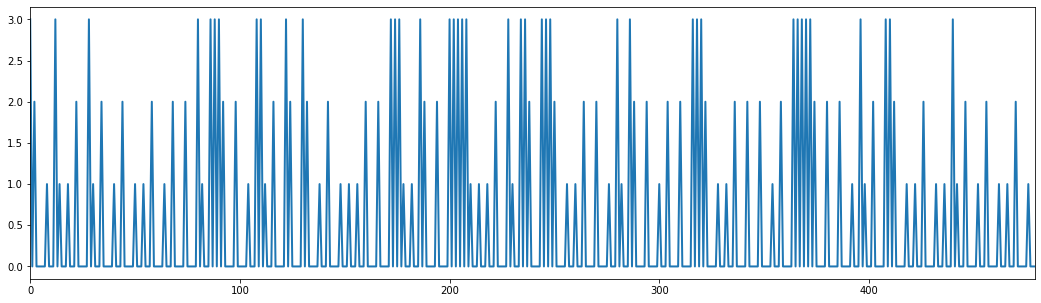

In [9]:
trial_sequence_3 = np.zeros(n_frames)

frame=0
for trial in range(np.size(trial_order)):
    trial_type = trial_order[trial]
    trial_sequence_3[frame] = trial_type
    if trial_type == 1:
        #duration of trial type 1 is 4 TRs
        frame = frame + 4
    elif trial_type == 2:
        #duration of trial type 2 is 6 TRs
        frame = frame + 6
    else: 
        #duration of trial type 3 is 2 TRs
        frame = frame + 2

#Plot it
plt.figure(figsize=(18,5))
plt.plot(trial_sequence_3, lw=2)
plt.xlim(0, len(trial_sequence_3)-1)
warnings.filterwarnings("ignore")

### 2. Compute the underlying neural responses

Compute the underlying neural responses for each of these three trial_sequences. For trial sequences 1 and 2, this is trivially just a scaled copy of the trial_sequence.

In [10]:
neural_response_amplitude = 2
neural_response_1 = neural_response_amplitude * trial_sequence_1
neural_response_2 = neural_response_amplitude * trial_sequence_2

For trial type 3, the idea is to incorporate some dynamics (adaptation) into the responses. For each trial, there is an initial transient response followed by a decay such that for the short trials we have a neural response that looks like: <br>
    2 1.37 0 0 <br>
And for the long trials we have neural response that looks like:<br>
    2 1.37 1.14 1.05 <br>
We can express the neural response in matrix notation which is worthwhile because we will use the same notation to express the design matrix below:<br>
    (neural response col vector) = (response matrix) * amps <br>
where response matrix is n_frames x 4 and contains appropriately placed 1's and 0's and amps is a vector of 4 numbers: 

In [11]:
amps = np.transpose([2, 1.37, 1.14, 1.05])
response_matrix = np.zeros((n_frames,4))

frame = 0
for trial in range(np.size(trial_order)):
    trial_type = trial_order[trial]
    if trial_type == 1:
        response_matrix[frame,0] = 1
        response_matrix[frame+1,1] = 1
        frame = frame + 4
    elif trial_type == 2:
        response_matrix[frame,0] = 1
        response_matrix[frame+1,1] = 1
        response_matrix[frame+2,2] = 1
        response_matrix[frame+3,3] = 1
        frame = frame + 6
    else: 
        frame = frame + 2

Compute the simulated neural response:

In [12]:
neural_response_3 = np.dot(response_matrix,amps)

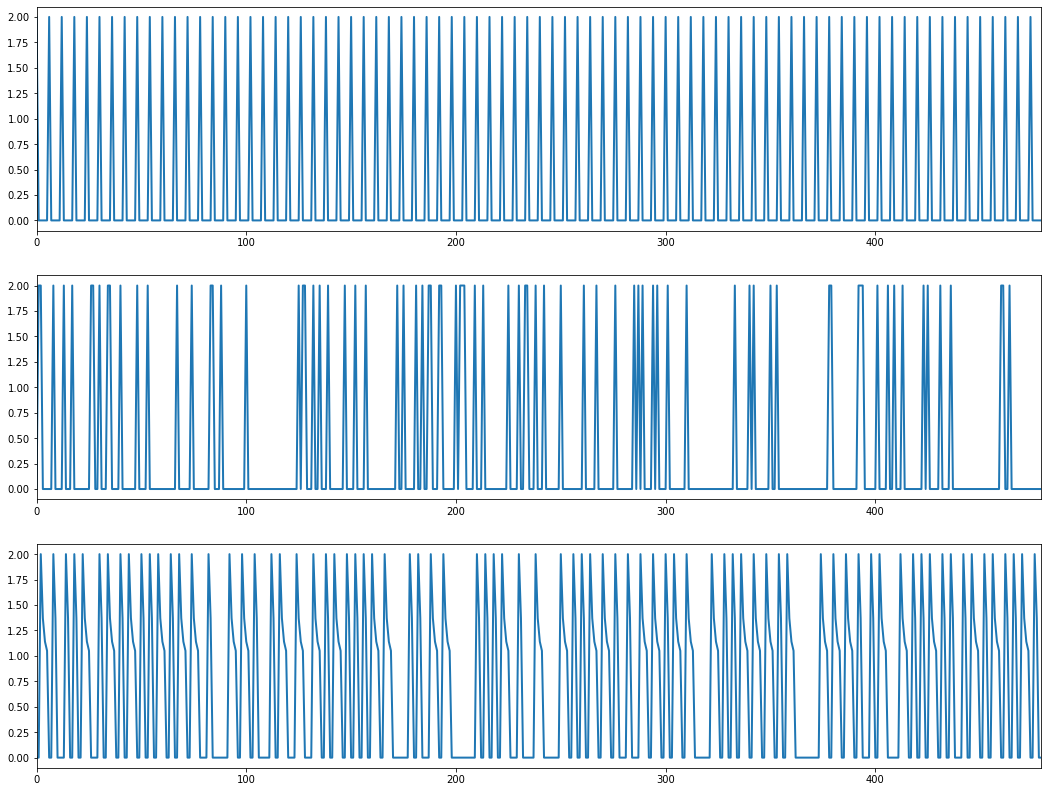

In [13]:
#Plot all of them
fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, ncols=1, figsize=[18,14])

ax1.plot(neural_response_1, lw=2)
ax1.set_xlim([0, len(neural_response_1)-1])
ax2.plot(neural_response_2, lw=2)
ax2.set_xlim([0, len(neural_response_2)-1])
ax3.plot(neural_response_3, lw=2)
ax3.set_xlim([0, len(neural_response_3)-1])
plt.show()

Print the first part of it so that you can see that it did the right thing:

In [14]:
print(neural_response_3[:30])

[0.   0.   2.   1.37 1.14 1.05 0.   0.   2.   1.37 0.   0.   0.   0.
 2.   1.37 0.   0.   2.   1.37 0.   0.   2.   1.37 1.14 1.05 0.   0.
 0.   0.  ]


### 3. Compute the fMRI responses 

Compute the fMRI responses from the underlying neural responses by convolving with the hrf. For the purpose of this tutorial, we won't bother adding baseline or drift (because you already know how to do that and what to do about it).

In [15]:
#HIRF parameters
tau = 2
delta = 2

In [16]:
# Noise Parameters
noise_sd = 0.1

Let's define a function to make our convolutions simpler:

In [17]:
def hrfconv(stim_vec, tau, delta, TR):
    
    """"Convolves stim_vec with a shifted gamma of width tau and delay delta
    
    stim_vec is the expected neural response in TRs
    tau, delta and TR are in seconds
    
    Returns conv_stim_vec, the convolved stim_vec
    """
    
    # Calculate the HIRF with these parameter values:
    t = np.arange(0,30)
    t_shift = np.maximum(t-delta,0)
    HIRF = (t_shift/tau)**2 * np.exp(-t_shift/tau) / (2*tau)
    temp = np.convolve(stim_vec,HIRF)
    conv_stim_vec = temp[:len(stim_vec)]

    return conv_stim_vec

In [18]:
# The three fmri responses (the second component is zero-mean random noise with standard deviation of noise_sd)

fmri_response_1 = hrfconv(neural_response_1,tau,delta,TR) + np.random.normal(0, noise_sd, len(neural_response_1)) 
fmri_response_2 = hrfconv(neural_response_2,tau,delta,TR) + np.random.normal(0, noise_sd, len(neural_response_2))
fmri_response_3 = hrfconv(neural_response_3,tau,delta,TR) + np.random.normal(0, noise_sd, len(neural_response_3))

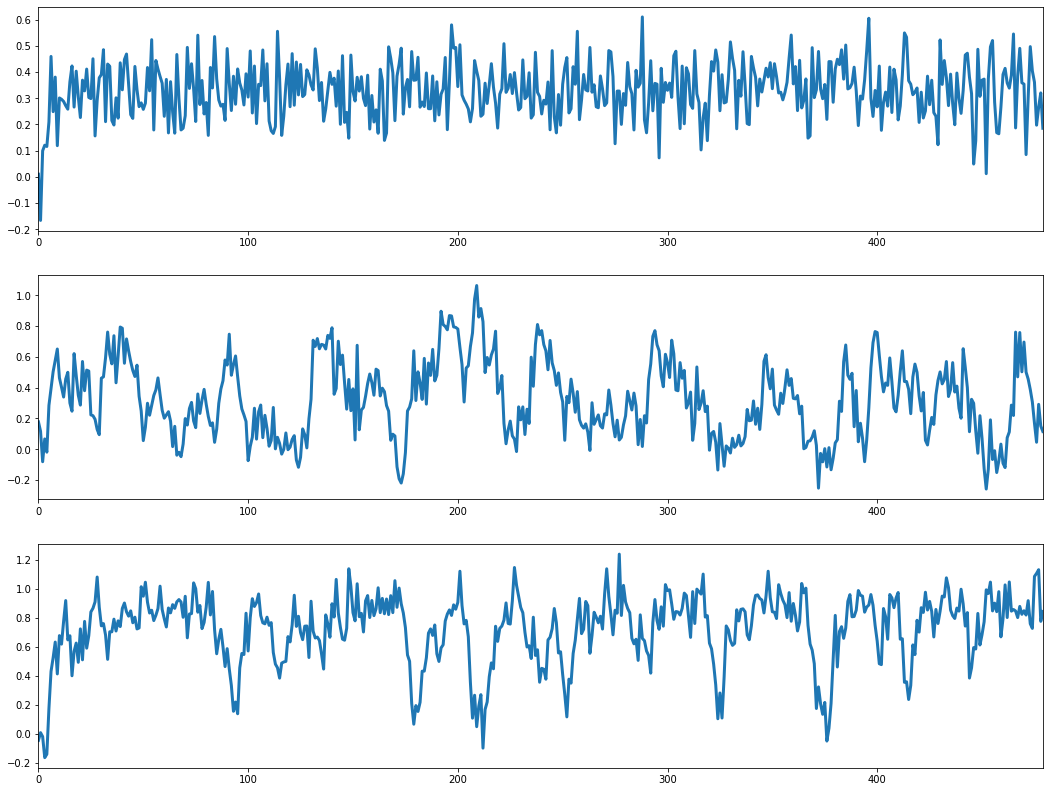

In [19]:
#Plot all of them
fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, ncols=1, figsize=[18,14])

ax1.plot(fmri_response_1, lw=3)
ax1.set_xlim([0, len(fmri_response_1)-1])
ax2.plot(fmri_response_2, lw=3)
ax2.set_xlim([0, len(fmri_response_2)-1])
ax3.plot(fmri_response_3, lw=3)
ax3.set_xlim([0, len(fmri_response_3)-1])
plt.show()

### 4. Basic regression analysis 

Build the corresponding design matrices. This is actually pretty trivial now that we've done all of the work above. The design matrices for experiements 1 and 2 are simply hrf convolved versions of the trial sequences (note no need for drift and mean in the design matrices)

In [20]:
design_matrix_1 = hrfconv(trial_sequence_1,tau,delta,TR)
design_matrix_2 = hrfconv(trial_sequence_2,tau,delta,TR)

The design matrix for experiment 3 is an hrf convolved version of the above response_matrix.

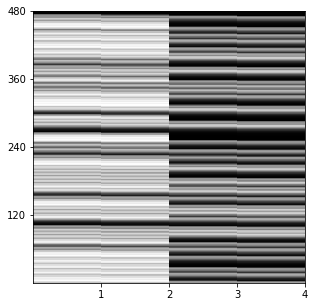

In [21]:
design_matrix_3 = np.zeros([n_frames,4])
design_matrix_3[:,0] = hrfconv(response_matrix[:,0],tau,delta,TR)
design_matrix_3[:,1] = hrfconv(response_matrix[:,1],tau,delta,TR)
design_matrix_3[:,2] = hrfconv(response_matrix[:,2],tau,delta,TR)
design_matrix_3[:,3] = hrfconv(response_matrix[:,3],tau,delta,TR)

#Plot it
plt.figure(figsize=(18,5))
xticks=(0.25, 0.5, 0.75, 1)
xlabels = (1, 2, 3, 4)
yticks=(0.25, 0.5, 0.75, 1)
ylabels = (120,240,360,480)
plt.imshow(design_matrix_3, extent=[0, 1, 0, 1], cmap='Greys_r')
plt.xticks(ticks = xticks, labels = xlabels)
plt.yticks(ticks = yticks, labels = ylabels)
plt.show()

Estimate (using linear regression) the underlying neural_response amplitudes. For experiments 1 and 2, you should find beta_1 = beta_2 = 2 (or at least something close to 2). Why isn't your answer exactly equal to 2? For experiment 3, you should find that beta_3 is a vector with values close to the 4 numbers specified above: [2 1.37 1.14 1.05].

First, we need to reshape the first two design_matrices so that they become two dimensional:

In [22]:
design_matrix_1 = np.reshape(design_matrix_1, (n_frames, 1))
design_matrix_2 = np.reshape(design_matrix_2, (n_frames, 1))

# calculate the pseudo-inverse design matrix
design_matrix_1_inv = np.linalg.pinv(design_matrix_1)
design_matrix_2_inv = np.linalg.pinv(design_matrix_2)
design_matrix_3_inv = np.linalg.pinv(design_matrix_3)

# then calculate the betas
beta_1 =  (design_matrix_1_inv).dot(fmri_response_1) 
beta_2 =  (design_matrix_2_inv).dot(fmri_response_2) 
beta_3 =  (design_matrix_3_inv).dot(fmri_response_3) 

print(beta_1)
print(beta_2)
print(beta_3)

[1.99423637]
[1.9750201]
[1.89911199 1.42584425 1.36037038 0.81626939]


### 5. Run a bunch of repeated simulations to characterize the variability in the parameter estimates. 

In [23]:
num_runs = 1000
betas_1 = np.zeros((1,num_runs))
betas_2 = np.zeros((1,num_runs))
betas_3 = np.zeros((4,num_runs))

for run in range(num_runs):
    fmri_response_1 = hrfconv(neural_response_1,tau,delta,TR) + np.random.normal(0, noise_sd, len(neural_response_1)) 
    fmri_response_2 = hrfconv(neural_response_2,tau,delta,TR) + np.random.normal(0, noise_sd, len(neural_response_2))
    fmri_response_3 = hrfconv(neural_response_3,tau,delta,TR) + np.random.normal(0, noise_sd, len(neural_response_3))
    
    design_matrix_1_inv = np.linalg.pinv(design_matrix_1)
    design_matrix_2_inv = np.linalg.pinv(design_matrix_2)
    design_matrix_3_inv = np.linalg.pinv(design_matrix_3)

    betas_1[0,run] =  (design_matrix_1_inv).dot(fmri_response_1) 
    betas_2[0,run] =  (design_matrix_2_inv).dot(fmri_response_2) 
    betas_3[:,run] =  (design_matrix_3_inv).dot(fmri_response_3) 

Plot histograms, labeled with the mean and std of the parameter estimates. Are the mean values what they should be or is there bias in the estimates? Is there a difference between the reliability of the parameter estimates in the different experiments? If so, why?

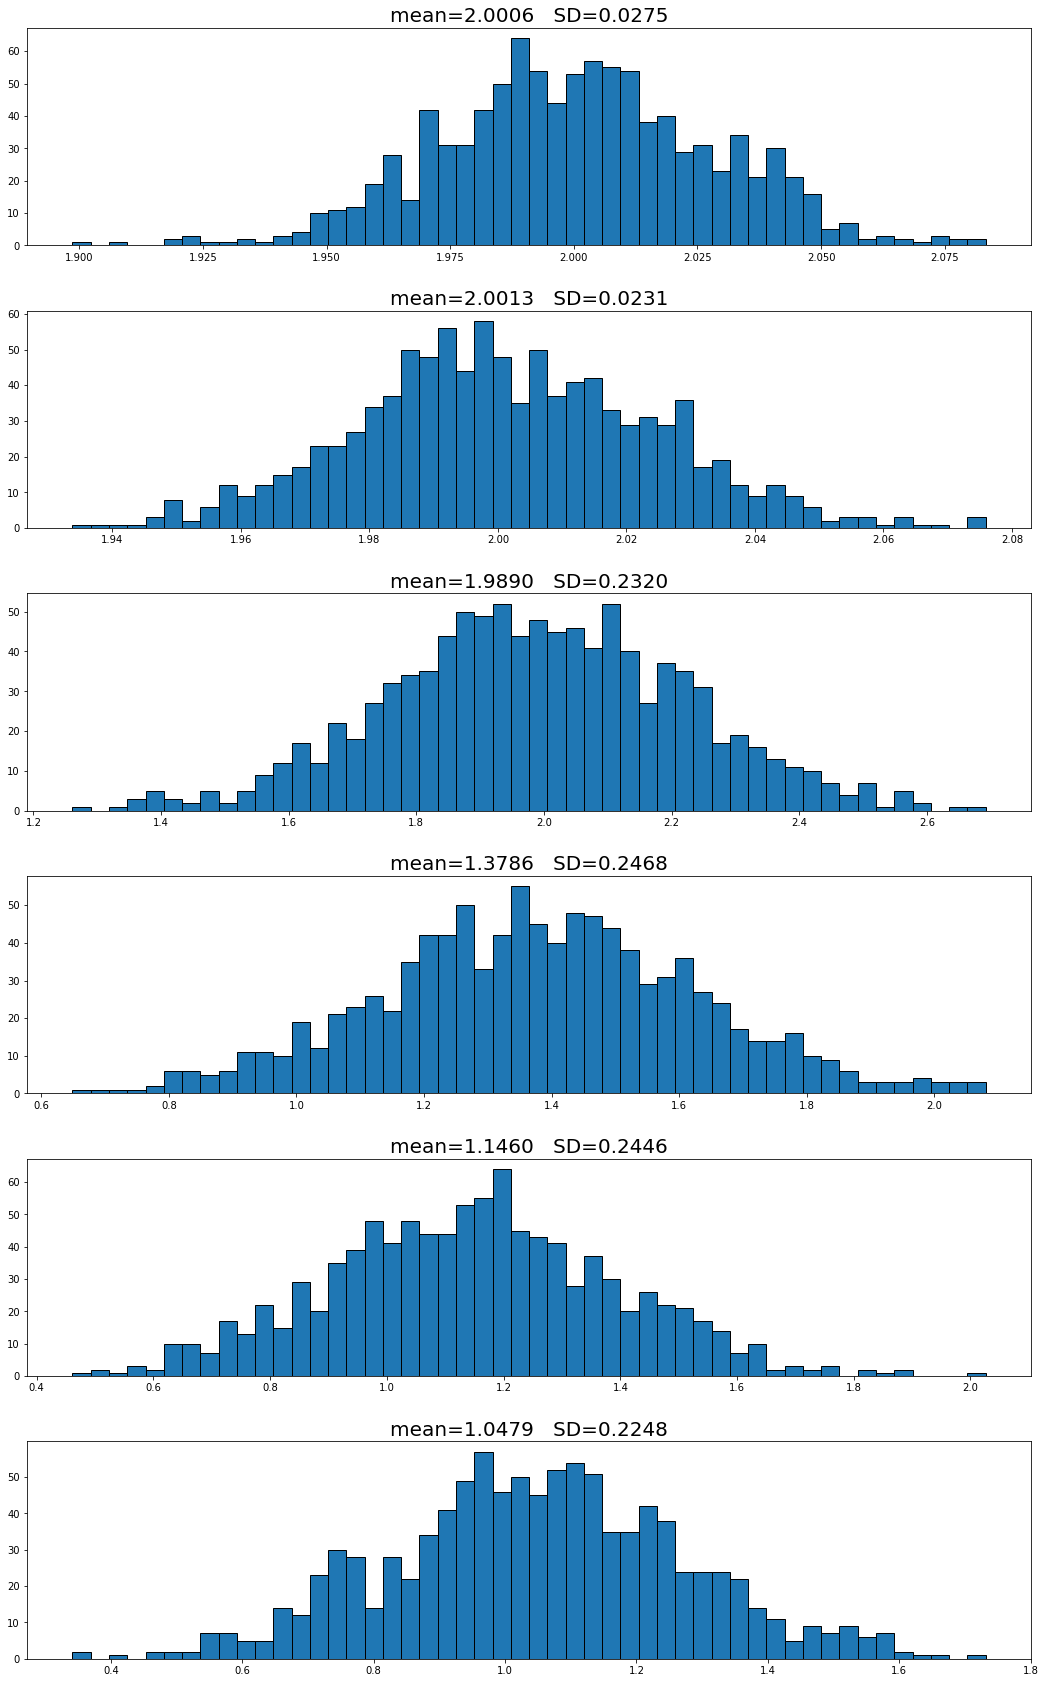

In [24]:
fig, [ax1, ax2, ax3, ax4, ax5, ax6] = plt.subplots(nrows=6, ncols=1, figsize=[18,30])
fig.subplots_adjust(hspace=0.3)

ax1.hist(np.squeeze(betas_1), bins = 50, edgecolor='black')
ax1.set_title('mean='+ str('{:.4f}'.format(np.mean(betas_1))) + '   SD='+ str('{:.4f}'.format(np.std(betas_1))), fontsize=20)
ax2.hist(np.squeeze(betas_2), bins = 50, edgecolor='black')
ax2.set_title('mean='+ str('{:.4f}'.format(np.mean(betas_2))) + '   SD='+ str('{:.4f}'.format(np.std(betas_2))), fontsize=20)
ax3.hist(betas_3[0,:], bins = 50, edgecolor='black')
ax3.set_title('mean='+ str('{:.4f}'.format(np.mean(betas_3[0,:]))) + '   SD='+ str('{:.4f}'.format(np.std(betas_3[0,:]))), fontsize=20)
ax4.hist(betas_3[1,:], bins = 50, edgecolor='black')
ax4.set_title('mean='+ str('{:.4f}'.format(np.mean(betas_3[1,:]))) + '   SD='+ str('{:.4f}'.format(np.std(betas_3[1,:]))), fontsize=20)
ax5.hist(betas_3[2,:], bins = 50, edgecolor='black')
ax5.set_title('mean='+ str('{:.4f}'.format(np.mean(betas_3[2,:]))) + '   SD='+ str('{:.4f}'.format(np.std(betas_3[2,:]))), fontsize=20)
ax6.hist(betas_3[3,:], bins = 50, edgecolor='black')
ax6.set_title('mean='+ str('{:.4f}'.format(np.mean(betas_3[3,:]))) + '   SD='+ str('{:.4f}'.format(np.std(betas_3[3,:]))), fontsize=20)
plt.show()

### 6. Estimating the HIRF in rapid event-related experiments: <br> Why you have to randomize the trial types, or jitter the timing. 

Experiment 1 was done with regular-spaced trials, all the same as one another. What impact does this have on the average response, averaged across repeated trials?

Clip out 24 sec epochs following the start of each trial, ignoring the 1st 24 sec to allow the hemodynamics to reach steady state and stopping 24 sec before the end of the run just to simplify things so that we don't need to deal with the partial epochs.

In [25]:
epoch_duration = 24
num_trials_1 = int(sum(trial_sequence_1[epoch_duration:n_frames-epoch_duration]))
responses_1 = np.zeros((num_trials_1, epoch_duration))
trial_num = 1

for frame in range(epoch_duration, n_frames-epoch_duration):
    if trial_sequence_1[frame] == 1:
        epoch = fmri_response_1[frame:frame+epoch_duration]
        responses_1[trial_num-1,:] = epoch
        trial_num = trial_num + 1
        
mean_response_1 = np.mean(responses_1, axis=0)
sem_response_1 = np.std(responses_1, axis=0)/np.sqrt(num_trials_1)

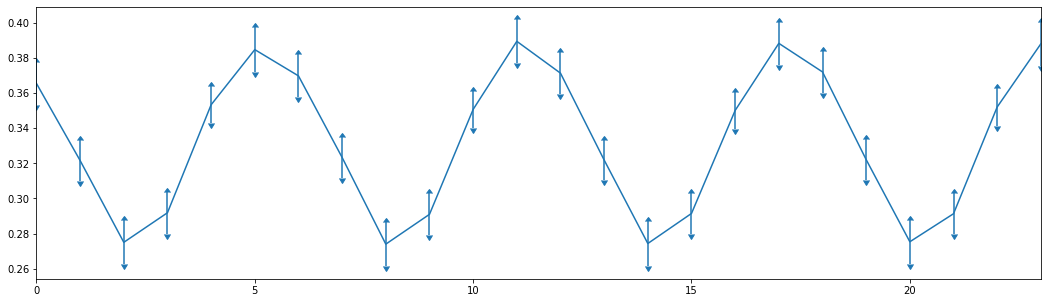

In [43]:
#Plot the mean response with error bars

plt.figure(figsize=(18,5))
plt.errorbar(range(0,epoch_duration), mean_response_1, yerr = sem_response_1, uplims=True, lolims=True)
plt.xlim([0, epoch_duration-1])
plt.show()

Compare this to what happens when the trials are pseudo-randomized in experiment 2:

In [27]:
epoch_duration = 24
num_trials_2 = int(sum(trial_sequence_2[epoch_duration:n_frames-epoch_duration]))
responses_2 = np.zeros((num_trials_2, epoch_duration))
trial_num = 1

for frame in range(epoch_duration, n_frames-epoch_duration):
    if trial_sequence_2[frame] == 1:
        epoch = fmri_response_2[frame:frame+epoch_duration]
        responses_2[trial_num-1,:] = epoch
        trial_num = trial_num + 1
        
mean_response_2 = np.mean(responses_2, axis=0)
sem_response_2 = np.std(responses_2, axis=0)/np.sqrt(num_trials_2)

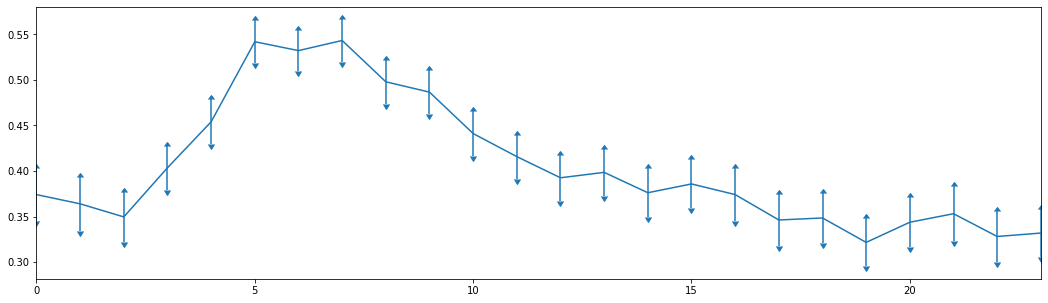

In [42]:
#Plot the mean response with error bars

plt.figure(figsize=(18,5))
plt.errorbar(range(0,epoch_duration), mean_response_2, yerr = sem_response_2, uplims=True, lolims=True)
plt.xlim([0, epoch_duration-1])
plt.show()

Why is it important to randomize? What do you have to randomize? Would it be ok to randomize EITHER the trial sequence or the time-intervals between trials?

### 7. Deconvolution for estimating the HRF in rapid event-related experiments

When computing the trial-triggered average (above) you are assuming that the trials are randomized. The fMRI response on any one trial depends on the trials preceding it because of the sluggishness of the HRF. If the trials are in a fully randomized order and you average across enough of them, then the trial-triggered average gives you the right answer. The effects of the preceding trial(s) average out and each trial type is equally likely. But you cannot depend on this if the trial types are not fully randomized (e.g., if the trial types depend on the subject's behavioral responses and the behavior isn't random) or if there aren't enough trials (so that there's not enough averaging). An alternative called "deconvolution" computes something very similar to the trial-triggered average but uses the actual trial sequence. The deconvolution analysis is also a variant of the basic regression analysis (above and in fmriTutorialPart2) but using a different design matrix.

Experiment 2 had pseudorandom trial sequence. Build the deconvolution matrix. As above, use an epoch_duration of 24 sec. 

The deconvolution matrix can be constructed from the start times for each trial type using
the function 'convmtx':

In [29]:
def convmtx(v, n): # Taken from https://github.com/awesomebytes/parametric_modeling/blob/master/src/by_hand_code/convmtx.py
    """Generates a convolution matrix
    
    Usage: X = convm(v,n)
    Given a vector v of length N, an N+n-1 by n convolution matrix is
    generated of the following form:
              |  v(0)  0      0     ...      0    |
              |  v(1) v(0)    0     ...      0    |
              |  v(2) v(1)   v(0)   ...      0    |
         X =  |   .    .      .              .    |
              |   .    .      .              .    |
              |   .    .      .              .    |
              |  v(N) v(N-1) v(N-2) ...  v(N-n+1) |
              |   0   v(N)   v(N-1) ...  v(N-n+2) |
              |   .    .      .              .    |
              |   .    .      .              .    |
              |   0    0      0     ...    v(N)   |
    And then it's trasposed to fit the MATLAB return value.     
    That is, v is assumed to be causal, and zero-valued after N.
    """
    N = len(v) + 2*n - 2
    xpad = np.concatenate([np.zeros(n-1), v[:], np.zeros(n-1)])
    X = np.zeros((len(v)+n-1, n))
    # Construct X column by column
    for i in range(n):
        X[:,i] = xpad[n-i-1:N-i]
    
    return X

In [30]:
epoch_duration = 24;
deconv_M = convmtx((trial_sequence_2),epoch_duration)

As above, ignore the first 24 seconds

In [31]:
start_frame = 24;
end_frame = len(trial_sequence_2)
fmri_response_crop = fmri_response_2[start_frame:end_frame]
deconv_M = deconv_M[start_frame:end_frame,:]

And here is what the convolution matrix looks like: 

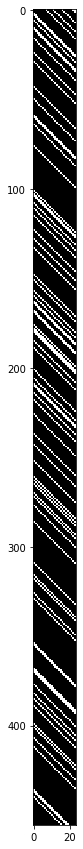

In [32]:
plt.figure(figsize=(15,15))
plt.imshow(deconv_M, cmap='Greys_r')
plt.show()

In [33]:
#Linear regression
deconv_M_inv = np.linalg.pinv(deconv_M)
b =  deconv_M_inv.dot(fmri_response_crop)

Pull apart the 3 HRFs corresponding to the 3 trial types:

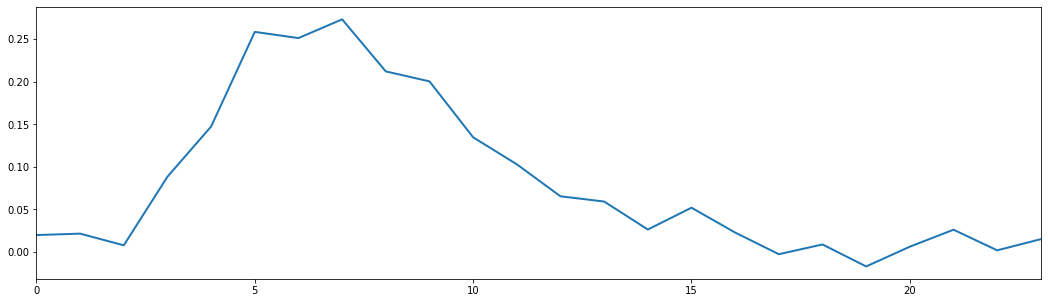

In [34]:
deconv_responses = b

#Plot them
plt.figure(figsize=(18,5))
plt.plot(range(0, epoch_duration),deconv_responses, lw=2)
plt.xlim([0, epoch_duration-1])
plt.show()

Put error bars on the deconvolved HRF by using the conf_int() method from StatsModels' RegressionResults:

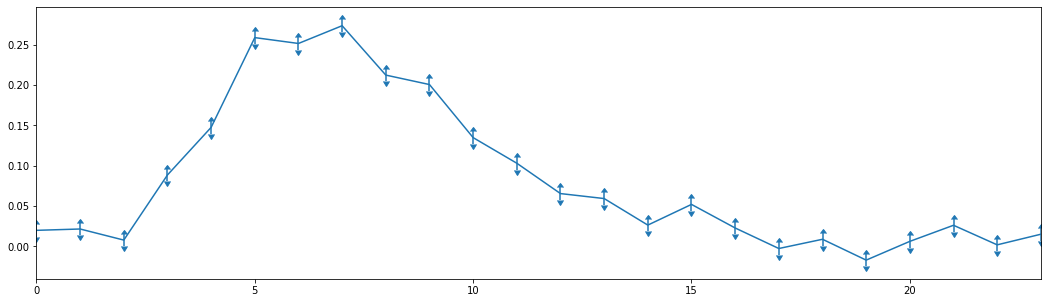

In [44]:
mod = sm.OLS(fmri_response_crop, deconv_M)
res = mod.fit()
b = res.params   
b_min = res.conf_int(0.5)[:,0]
b_max = res.conf_int(0.5)[:,1]

#Plot it
plt.figure(figsize=(18,5))
plt.errorbar(range(0, epoch_duration), b, yerr = [b-b_min, b_max-b], uplims=True, lolims=True)
plt.xlim([0, epoch_duration-1])
plt.show()

Notice that this result looks cleaner and nicer than the trial-triggered average above. Why? <br>

Now let's do this for experiment 3. Recall that there were 3 trial types, but the 3rd trial type was 'no stimulus' (i.e., all 0s), so we ignore it. <br>

Build the deconvolution matrix. As above, use an epoch_duration of 24 sec.

In [47]:
epoch_duration = 24

The deconvolution matrix consists of 2 parts, each containing 24 columns. Each part of the deconvolution matrix can be constructed from the start times for each trial type using the function 'convmtx'.

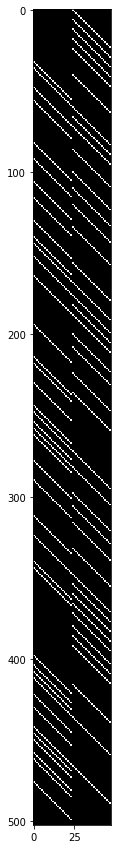

In [49]:
deconv_M1 = convmtx(trial_sequence_3 == 1, epoch_duration)
deconv_M2 = convmtx(trial_sequence_3 == 2, epoch_duration)
deconv_M = np.concatenate((deconv_M1,deconv_M2), axis=1)

# Plot it
plt.figure(figsize=(15,15))
plt.imshow(deconv_M, cmap='Greys_r')
plt.show()

As above, ignore the first 24 seconds.

In [50]:
start_frame = 24;
end_frame = len(trial_sequence_3)
fmri_response_crop = fmri_response_3[start_frame:end_frame]
deconv_M = deconv_M[start_frame:end_frame,:]

In [51]:
#Linear regression
deconv_M_inv = np.linalg.pinv(deconv_M)
b =  deconv_M_inv.dot(fmri_response_crop)

Pull apart the 3 HRFs corresponding to the 2 trial types

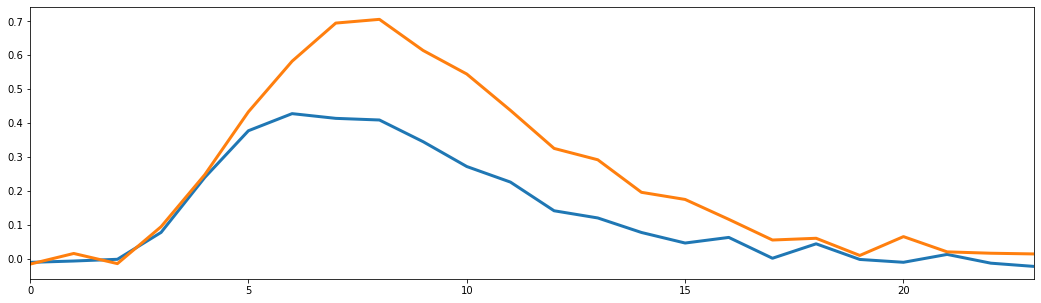

In [53]:
deconv_responses = np.zeros((2,epoch_duration))
deconv_responses[0,:] = b[0:epoch_duration]
deconv_responses[1,:] = b[epoch_duration:2*epoch_duration]


#Plot them
plt.figure(figsize=(18,5))
plt.plot(range(0, epoch_duration),deconv_responses[0,:], lw=3)
plt.plot(range(0, epoch_duration),deconv_responses[1,:], lw=3)
plt.xlim([0, epoch_duration-1])
plt.show()

### 8. Use nonlinear least-squares to estimate parameters of HIRF (amplitude, tau and delta)<br> along with estimates of the parameters characterizing the underlying neural activity.

We are going to use the function `least_squares` from `scipy.optimize`:
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html

First, we need to define a few things.

Initial guess x0<br>
The first element is the initial guess at the amplitude <br>
The second element is the initial guess at tau <br>
The third element is the initial guess at delta <br>

In [54]:
x0 = [1, 3, 3]

Then, we will define our cost function, which computes the vector of residuals:

In [55]:
def fitfunc(x, data, stim_vec, TR):
    """Generates a convolution matrix. 
    
    Computes the expected mri signal by convolving stim_vec with 
    a shifted gamma of width tau and delay delta and multiplying 
    by an amplitude where amplitude = x[0], tau=x[1], delta=x[2]
    (see hrfconv for the convolution)
    
    stim_vec is the expected neural response in TRs 
    tau, delta and TR are in seconds 
    
    Returns the difference between the data and the expected mri signal
    """
    
    amp = x[0]
    tau = x[1]
    delta = x[2]

    conv_stim_vec = hrfconv(stim_vec,tau,delta,TR)

    y = data - amp*conv_stim_vec

    return y

Now we are ready to call `least_squares` for experiment 1. <br>You should get an answer close to
[2,2,2]. The first number is the estimate of neural response amplitude. Second is tau estimate. Third is delta estimate.

In [56]:
x1 = least_squares(fitfunc, x0, method='trf', args = (fmri_response_1,trial_sequence_1,TR))
x1.x

array([2.01079442, 1.86626191, 2.14348427])

Parameter estimates for experiment 2.<br>
Again, answer should be close to [2,2,2]

In [57]:
x2 = least_squares(fitfunc, x0, method='trf', args = (fmri_response_2,trial_sequence_2,TR))
x2.x

array([2.03734762, 1.97055248, 2.01378508])

For experiment 3 we have to work a bit harder. The first four are initial guesses of the neural response parameters. The next two are initial guesses for tau and delta. 

In [58]:
x0 = [2,1.4,1.1,1,2,2]

We also need to modify our cost function:

In [59]:
def fitfunc2(x, data, response_matrix, TR):
    """Generates a convolution matrix. 
    
    Computes the expected mri signal by convolving stim_vec with 
    a shifted gamma of width tau and delay delta and multiplying 
    by an amplitude where amplitudes = x[0:3], tau=x[4], delta=x[5]
    (see hrfconv for the convolution)
    
    stim_vec is the expected neural response in TRs 
    tau, delta and TR are in seconds 
    
    Returns the difference between the data and the expected mri signal
    """
    
    tau = x[4]
    delta = x[5]

    design_matrix = np.zeros([len(data),4])
    design_matrix[:,0] = hrfconv(response_matrix[:,0],tau,delta,TR)
    design_matrix[:,1] = hrfconv(response_matrix[:,1],tau,delta,TR)
    design_matrix[:,2] = hrfconv(response_matrix[:,2],tau,delta,TR)
    design_matrix[:,3] = hrfconv(response_matrix[:,3],tau,delta,TR)

    y = data - design_matrix.dot(x[0:4])

    return y

Get the estimates:

In [60]:
x3 = least_squares(fitfunc2, x0, method='trf', args = (fmri_response_3,response_matrix,TR))
x3.x

array([0.24265224, 3.05646813, 0.09445509, 2.1909862 , 2.07880025,
       1.31889664])

Notice that this might fail (depending on your particular randomization of the trial sequence). The fit might hit the maximum number of iterations and fail to come up with a reasonable estimate even though we started very close to the correct solution. If `least_squares` does come up with estimates, the estimated neural responses might not be monotically decreasing. Why should it fail like this?

Let's try a different function which is constrained to be monotonically decreasing:<br>
$a+b*exp(-c*t)$



In [61]:
def fitfunc3(x, data, response_matrix, TR):
    """Generates a convolution matrix. 
    
    Computes the expected mri signal by convolving stim_vec with 
    a shifted gamma of width tau and delay delta and multiplying 
    each column by an amplitude where amplitudes = x[0:3], tau=x[4], 
    delta=x[5] (see hrfconv for the convolution)
    
    stim_vec is the expected neural response in TRs 
    tau, delta and TR are in seconds 
    
    Returns the difference between the data and the expected mri signal
    """
    
    t = [0,1,2,3]
    amp = x[0]+x[1]*exp(-x[2]*t);
    tau = x[4]
    delta = x[5]

    design_matrix = np.zeros([len(data),4])
    design_matrix[:,0] = hrfconv(response_matrix[:,0],tau,delta,TR)
    design_matrix[:,1] = hrfconv(response_matrix[:,1],tau,delta,TR)
    design_matrix[:,2] = hrfconv(response_matrix[:,2],tau,delta,TR)
    design_matrix[:,3] = hrfconv(response_matrix[:,3],tau,delta,TR)

    y = data - design_matrix.dot(x[0:4])

    return y

In [62]:
x3 = least_squares(fitfunc2, x0, method='trf', args = (fmri_response_3,response_matrix,TR))
x3.x

array([0.24265224, 3.05646813, 0.09445509, 2.1909862 , 2.07880025,
       1.31889664])